In [1]:
# Do more highly-recommended stocks outperform lowly-rated ones?
# Run 1) Slightly underperformed
# Run 2) Slightly overperformed
# Run 3) Slightly overperformed
# Run 4) Slightly underperformed
    # This would need to be run for larger sample sizes and more processing to be conclusive.
    # However, this satisfies my own curiosity - it does seem like the highest analyst score stocks do better!

import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
from IPython.display import display
from sklearn.metrics import r2_score
import math
pd.set_option('display.max_columns',500)

In [2]:
# Get a list of all SP500 companies
query=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500 = list(query[0]['Symbol'].values)

In [3]:
def get_history_and_recommendation_data(stock_ticker,period='5y',days_out=180,min_recommendations=5):
    # Prepare yfinance
    print('Results for: '+stock_ticker)
    stock=yf.Ticker(stock_ticker)
    
    # Get historical trading data
    try:
        history=stock.history(period=period)
    except:
        print('No history data for '+stock_ticker)
        return
    
    # Get recommendations
    try:
        recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
    except:
        print('No analyst recommendation data for '+stock_ticker)
        return
    recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
    recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
    recommendations['Good Until']=recommendations\
        [['Next Recommendation',str(days_out)+' Days From']]\
            .min(axis=1) # Define how long a recommendation lasts for - lowest of [days_out] or
                # [Until a new recommendation by that firm]

    # Process the recommendation values
#     print('Recommendation values: '\
#           +str(sorted(recommendations['To Grade'].dropna().unique()))) # Print out the unique recommendation grades
    assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Strong Sell':1, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
    recommendations['Assigned Value']=\
    recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
    
    # Store the dataframes in sqlite memory
    conn = sqlite3.connect(':memory:')
    history.to_sql('history', conn, index=True)
    recommendations.to_sql('recommendations', conn, index=False)
    
    # Get average analyst assigned scores by day using SQL
    qry = '''
    select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value',
    count(r.'assigned value') as 'Count of Ratings'
    from history h
    left join ( 
    select * from recommendations r 
    where r.firm in 
    (select firm from recommendations group by firm having count(date)>='''+str(int(min_recommendations))+''')
        -- Join recommendations, but only for firms with at least minimum recommendations recommendations
    ) r
    on date(h.date) between date(r.date) and date(r.'good until')
    group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
        '''
    df = pd.read_sql_query(qry, conn).sort_values(by='Date')
    df['Date']=pd.to_datetime(df['Date'])
    return df

In [4]:
def get_stock_rating_and_return(df,minimum_average_ratings=3,trim_start=100):
    try:
        df=df.iloc[100:,:]
    except:
        print('Missing data for this stock.')
        return None, None
    if df['Count of Ratings'].mean() < minimum_average_ratings:
        print('Not enough ratings for this stock.')
        return None, None
    if df['Average Assigned Value'].isnull().values.any(): # If there are any periods without ratings values
        print('This stock has periods of missing recommendations.')
        return None, None
    else:
        first_open=df.iloc[[0]]['Open'].values[0]
        last_close=df.iloc[[-1]]['Close'].values[0]
        total_return_fraction=last_close/first_open
        average_rating=df['Average Assigned Value'].mean()
        count_days=df.shape[0]
        return_rate = 100*\
            (total_return_fraction**(1/count_days)-1) # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)
    return return_rate, average_rating

In [5]:
import random
stocks = random.sample(sp500,50)
store_values = []
counter = 1
for stock in stocks:
    returns,rating = get_stock_rating_and_return(get_history_and_recommendation_data(stock))
    store_values.append([stock,returns,rating])
    if counter % 10 == 0:
        print(str(counter)+' stock data downloaded.')
    counter += 1

Results for: ALK
Results for: NOW
Results for: MSI
Results for: JNJ
This stock has periods of missing recommendations.
Results for: CDAY
This stock has periods of missing recommendations.
Results for: NDAQ
This stock has periods of missing recommendations.
Results for: AON
Results for: ABBV
Results for: FTNT
Results for: PAYX
10 stock data downloaded.
Results for: ANTM
Results for: BKR
This stock has periods of missing recommendations.
Results for: IDXX
Not enough ratings for this stock.
Results for: APA
Not enough ratings for this stock.
Results for: PEG
Results for: FB
Results for: UDR
Not enough ratings for this stock.
Results for: URI
Results for: NTRS
Results for: PXD
20 stock data downloaded.
Results for: ORLY
Results for: STT
Results for: MHK
Results for: ROL
Not enough ratings for this stock.
Results for: KMI
This stock has periods of missing recommendations.
Results for: ADI
Results for: DLR
Results for: ECL
This stock has periods of missing recommendations.
Results for: MKC
N

In [6]:
# Get SPY (SP500 ETF) returns for comparison
spy=yf.Ticker('SPY')
df=spy.history(period='5y')
df=df.iloc[100:,:]
first_open=df.iloc[[0]]['Open'].values[0]
last_close=df.iloc[[-1]]['Close'].values[0]
total_return_fraction=last_close/first_open
count_days=df.shape[0]
return_rate = 100*\
    (total_return_fraction**(1/count_days)-1)

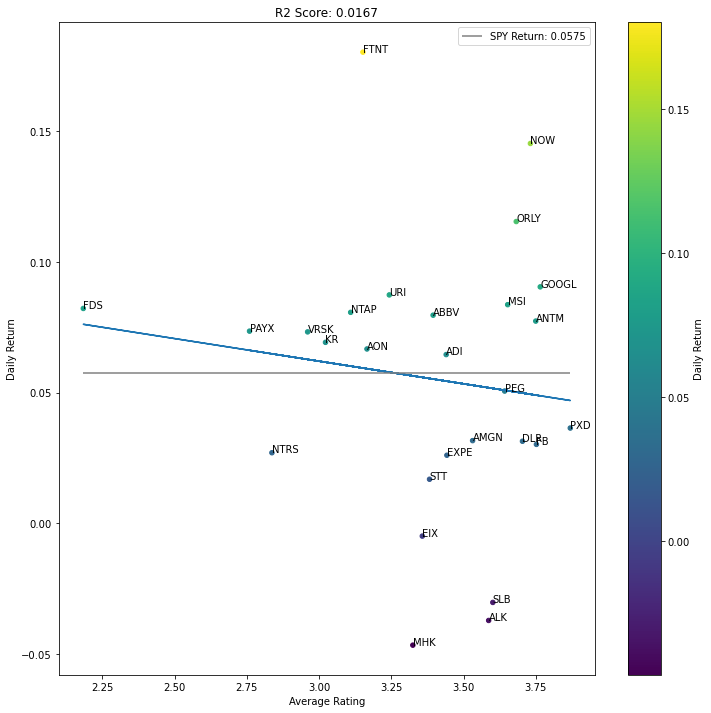

In [7]:
# Plot the df values
fig,ax = plt.subplots()
df = pd.DataFrame(store_values,columns=['Ticker','Daily Return','Average Rating']).dropna()
df.plot(x='Average Rating',y='Daily Return',kind='scatter',figsize=(12,12),ax=ax,
       c='Daily Return',colormap='viridis',)
m,b = np.polyfit(x=df['Average Rating'],y=df['Daily Return'], deg=1)
plt.plot(df['Average Rating'],df['Average Rating']*m+b)
title = 'R2 Score: '+str(round(r2_score(df['Daily Return'],df['Average Rating']*m+b),4))
plt.hlines(return_rate,df['Average Rating'].min(),df['Average Rating'].max(),color='grey',
           label='SPY Return: '+str(round(return_rate,4))) # SPY returns line for reference
plt.title(title)
plt.legend()
for idx, row in df.iterrows():
        ax.annotate(row['Ticker'],(row['Average Rating'],row['Daily Return']))
plt.show()

In [8]:
# Correlation matrix
df.corr()

,Daily Return,Average Rating
Daily Return,1.000000,-0.129264
Average Rating,-0.129264,1.000000


In [9]:
# Get average returns above various ratings
for i in [2,2.5,3,3.25,3.5,3.75,4]:
    print(str(i)+' minimum rating average return: '+str(round(df[df['Average Rating']>=i]['Daily Return'].mean(),4)))

2 minimum rating average return: 0.0556
2.5 minimum rating average return: 0.0546
3 minimum rating average return: 0.0541
3.25 minimum rating average return: 0.0423
3.5 minimum rating average return: 0.0521
3.75 minimum rating average return: 0.0524
4 minimum rating average return: nan
